# 1. Photon Counting Using TES
Counting individual photons is an effective method for analyzing quantum states that can be represented in the fock basis. A transition edge sensor (TES) is one device that is well-suited to counting individual photons. In a TES, the sensing metal is cooled enough to be a superconductor. However, the temperature is on the edge of the transition to a normal conductor with non-zero resistance. When a photon strikes the sensor, the sensing metal increases in temperature slightly, leading to a large change in resistance which can be detected. Following a photon absorption, the resistance decreases exponentially. Thus, the number of photons that hit the detector can be determined by investigating different resistance levels. However, if too many photons heat up the detector, it becomes heated and “saturated” to the regime of normal conductors, where resistance does not change with any significance after photon strikes. Thus, when using a TES, one must keep in mind that there is a maximum photon number that can be resolved and that there is a short delay period after a photon strike when the TES cools back to baseline levels. 

## 1.1 Basic Peak Analysis
Import a dataset using scipy. matA contains raw data for an OPO (optical parametric oscillator) channel while matB contains raw data for the filter cavity channel.

In [4]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

matA = scipy.io.loadmat('./data/2017.10.18_16.58.07_1.A.mat')
matB = scipy.io.loadmat('./data/2017.10.18_16.58.07_1.B.mat')

x_opo = matA['T1'][0,:]
y_opo = matA['Y1'][0,:]

x_filter = matB['T1'][0,:]
y_filter = matB['Y1'][0,:]


The first step is to shift the data to be centered around 0. A portion of the data is plotted below as well.

filter mean is: 7942.185154080391
opo mean is: 7958.92577278614


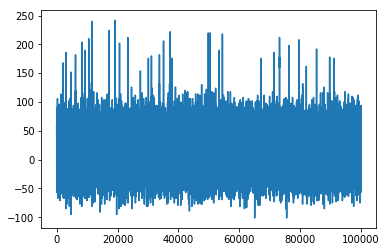

In [29]:
#subtract out the zero level
yt_filter = y_filter.astype(float)
filter_mean = np.mean(yt_filter)
yt_filter -= filter_mean
print("filter mean is: " + str(filter_mean))

yt_opo = y_opo.astype(float)
opo_mean = np.mean(yt_opo)
yt_opo -= filter_mean
print("opo mean is: " + str(opo_mean))

plt.plot(yt_opo[:100000])
plt.show()

The next step is to plot a histogram of the peak data to get an idea for the thresholds for certain number of photons. The below histogram is plotted on the log scale and each stair step can represent another photon number.

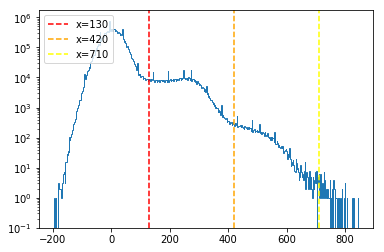

In [40]:
# Vertical lines drawn at 130, 420, 710 corresponding to 1, 2, or 3 photons
# These thresholds are handpicked, and frequencies are still rather large at the threshold values, thresholds should ideally be at dips
plt.hist(yt_opo,bins=500,log=True,histtype='step')
plt.axvline(x=130,linestyle='dashed', color='red',label='x=130')
plt.axvline(x=420,linestyle='dashed', color='orange', label='x=420')
plt.axvline(x=710,linestyle='dashed', color='yellow', label='x=710')
plt.legend()
plt.show()

## 1.2 Peak Finding
The above can give an idea of what values the TES outputs based on the photon number. Now, we will analyze different peaks and their heights. Consider a single peak.

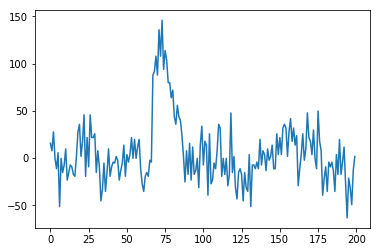

In [57]:
ys1p = yt_filter[6400:6600]
xs1p = x_filter[6400:6600]
plt.plot(ys1p)
plt.show()

The total peak is around 25 samples wide. Let's use Scipy's peak finder to detect it. There are a number of parameters to find peaks from, but to find this peak all we need is the local maximum that is above ~75. Scipy's peak finder will look for points above 75 and which are at least 20 samples away from larger peaks. 

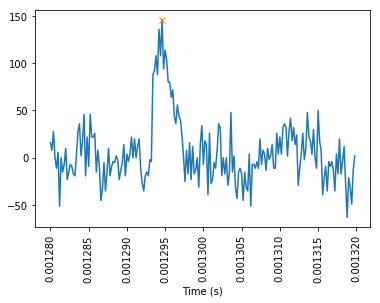

In [60]:
from scipy.signal import find_peaks

#look for peaks above 1 photon threshold and with horizontal distance ~ width
peaks, _ = find_peaks(ys1p, height=75,distance=20) #peaks are the x indices

# plot graph with detected peaks over it
plt.plot(xs1p,ys1p)
plt.plot(xs1p[peaks], ys1p[peaks], "x")

#formatting
plt.xticks(rotation='vertical')
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel("Time (s)")
plt.show()

Scipy's peak finder has a number of parameters including height, distance, "prominence", and width. Prominence is defined by looking for the lowest value on the left and right sides of the peak (over a certain window). The prominence is, then, the difference between the peak height and max(left_lowest,right_lowest). By setting a prominence value, we can eliminate peaks that are above the height threshold, but are just random noise local maxima. The way the peak finder works is that it first selects all points that are all above the height threshold and stores them in a list. All these points are sorted by their height. Next, these points are iterated over, checking if the conditions set by the parameters are met. For example, if the second point in the list is only 2 samples points away from the first one, it is not a local maxima and is thus not considered to be a peak. Each of the parameters filters out possible peaks until only the desired peaks are left in the end.

Thus, prominence can be the answer to handling "pileup" peaks which occur as the TES cools down from another photon strike. Consider the below using the previous peak analysis.

7965.74


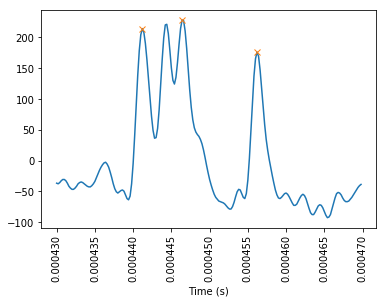

In [69]:
#load another dataset with pileup peaks
mat2A = scipy.io.loadmat('./data/TES _DATA_NOV_6th/2018.11.06_23.59.20_1.A.mat')
mat2B = scipy.io.loadmat('./data/TES _DATA_NOV_6th/2018.11.06_23.59.20_1.B.mat')
x1 = mat2A['T1'][0,:][2150:2350]
y1 = mat2A['Y1'][0,:][2150:2350]
y1 = y1.astype(float)
print(np.mean(y1))
y1 -= np.mean(y1)

peaks, _ = find_peaks(y1, height=50,distance=15) #peaks are the x indices

# plot graph with detected peaks over it, convert to us
plt.plot(x1,y1)
plt.plot(x1[peaks], y1[peaks], "x")

#formatting
plt.xticks(rotation='vertical')
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel("Time (s)")
plt.show()


The second peak is missed since it is not far away enough from the first peak. However, if we reduce the distance value, noise in the data can lead to multiple peaks when there really is one. The solution is to use prominence. The second peak jumps up again high, and this corresponds to a larger prominence value than noise. 

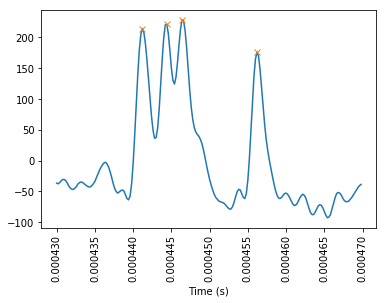

In [71]:
#decrease the distance to 10, but set a "prominence" value of 50
peaks, _ = find_peaks(y1, height=50,distance=10,prominence=50) #peaks are the x indices

# plot graph with detected peaks over it, convert to us
plt.plot(x1,y1)
plt.plot(x1[peaks], y1[peaks], "x")

#formatting
plt.xticks(rotation='vertical')
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel("Time (s)")
plt.show()

Using peak statistics is an alternative approach to determining photon number thresholds. We can obtain the peak heights and plot a histogram of just those to see if there are ranges of peak heights that correspond to certain photon numbers. Lets perform this on a large dataset. 

filter mean is: 8056.048910558224
opo mean: 8069.1725707650185
peak#:  3209


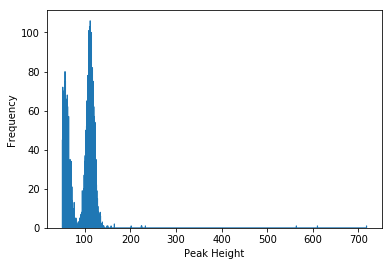

In [97]:
#data importing and zeroing
dataSet = "Nov29/Nov_21_Data_Phase_6/Displacement_ND_7.0_both/2018.11.22_04.50.04_1"
matA = scipy.io.loadmat('./data/'+dataSet+'.A.mat')
matB = scipy.io.loadmat('./data/'+dataSet+'.B.mat')

xf = matB['T1'][0,:]
yf = matB['Y1'][0,:]

xo = matA['T1'][0,:]    
yo = matA['Y1'][0,:]

#subtract out the zero level
yt_filter = yf.astype(float)
filter_mean = np.mean(yt_filter)
yt_filter -= filter_mean
print("filter mean is: " + str(filter_mean))

yt_opo = yo.astype(float)
opo_mean = np.mean(yt_opo)
yt_opo -= opo_mean
print("opo mean: " + str(opo_mean))

#function to plot histogram of data based on min height.
def peakAnalyzer(x,y, height):
    #find peaks in filter cavity
    peaks, _ = find_peaks(y, height=height,distance=7, prominence=60) #peaks are the x indices
    print("peak#: ", len(peaks))
    
    #histogram of filter peak heights
    plt.figure()
    plt.hist(y[peaks], bins=1500, log=False,histtype='step')
    plt.xlabel("Peak Height")
    plt.ylabel("Frequency")
    plt.show()

peakAnalyzer(xf,yt_filter,50)


According to this histogram, the main single photon peak is actually around 100 height. The proper threshold for photon numbers should actually be 86. The peak below this is due to background radiation noise. Since we are looking at the filter cavity, there are almost no double or triple photon peaks, but we can set 2 photons to be above 150 and 3 photons somewhere above 300. This process can be repeated for different data sets to determine photon number thresholds. Thus, a program that does this repeatedly for a dataset is  `thresholdChooser.py`

# 2. Heralding Ratio and Wigner Function
Now that we can find peaks in the data, we can use that to derive statistics like the heralding ratio and Wigner function. The heralding ratio is the number of coincidences (single photon peaks in filter cavity at same time as peaks in OPO) divided by the single photon peaks in the filter cavity. One way to do this is to multiply the two channels elementwise together and look for peaks in the result after clipping values that are not peaks to 0. A value in this multiplied channel is only large if it was significant in both the filter channel *and* OPO channel at the same time.

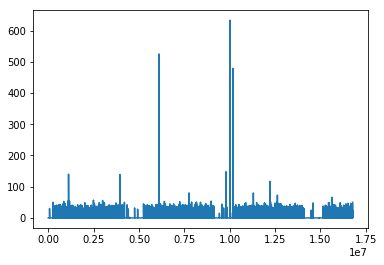

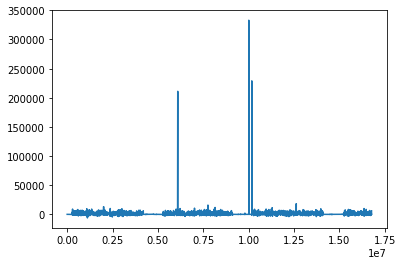

filter peak#:  2020
Heralding ratio:  0.6440594059405941


In [104]:
yt_f = np.clip(yt_filter, a_min=85,a_max=None)
yt_f -= 85

plt.plot(yt_f)
plt.show()

filter_peaks, _ = find_peaks(yt_f,height=0,distance=10)

mulChannel = yt_f * yt_opo
plt.plot(mulChannel)
plt.show(block=True)

print("filter peak#: ", len(filter_peaks))

mul_peaks, _ = find_peaks(mulChannel, height=1000,distance=10) #peaks are the x indices

print("Heralding ratio: ",len(mul_peaks)/len(filter_peaks))

The other alternative is to find peaks seperately in both channels, and then search for coincidences by comparing if a filter peak also lies in the opo peak. The only issue is recognizing that the peak need not be at the same exact sample in the OPO channel, but it could lie in a range/window outside. We need to search if there is a an OPO peak at filter_peak +-peak_width/2. As we are detecting the peaks, we are also classifying them into single, double, or triple photon bins for both channels. In this manner, we can calculate the Wigner function value of the data:

*(zero_coincidences-single_coincidences+double_coincidences-triple_coincidences)/len(filter_peaks)/3.1415926)*

Higher photon number coincidences are very unlikely for the current data we are dealing with. The code below shows the results with a low displacement and plots the heralding ratio at different window widths. The single photon level was set to 86 for the filter and OPO channels using `thresholdChooser.py` alongside the other photon ranges specified in the beginning of the code.

0 photon opo coincidence: 1843
1 photon opo coincidence: 14
2 photon opo coincidence: 4
3 photon opo coincidence: 0
wigner:  0.3135207046360438
peak width: 0  ratio: 0.007522837184309511
0 photon opo coincidence: 1553
1 photon opo coincidence: 283
2 photon opo coincidence: 22
3 photon opo coincidence: 3
wigner:  0.22047364335835268
peak width: 2  ratio: 0.15206878022568512
0 photon opo coincidence: 970
1 photon opo coincidence: 846
2 photon opo coincidence: 41
3 photon opo coincidence: 4
wigner:  0.02753782512078726
peak width: 4  ratio: 0.45459430413756047
0 photon opo coincidence: 777
1 photon opo coincidence: 1019
2 photon opo coincidence: 60
3 photon opo coincidence: 5
wigner:  -0.031984927314206324
peak width: 6  ratio: 0.5475550779150994
0 photon opo coincidence: 747
1 photon opo coincidence: 1040
2 photon opo coincidence: 69
3 photon opo coincidence: 5
wigner:  -0.039168707780498656
peak width: 8  ratio: 0.5588393336915637
0 photon opo coincidence: 733
1 photon opo coincidence: 

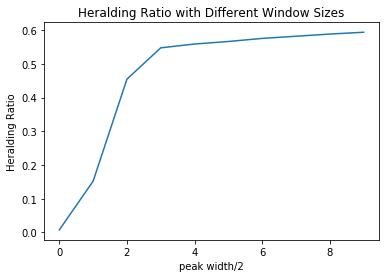

In [105]:
# filename
dataSet = "Nov29/Nov_21_Data_Phase_6/Displacement_ND_7.7_both/2018.11.22_04.57.37_1"

filter_single_photon_level = 86
opo_single_photon_level = 86

photon_ranges = [150, 250] # 2peak min, 3 peak min
opo_photon_ranges = [180,240] #,310 for triple

matA = scipy.io.loadmat('./data/'+dataSet+'.A.mat')
matB = scipy.io.loadmat('./data/'+dataSet+'.B.mat')

# This is the filtering Channel
x1 = matB['T1'][0,:]
y1 = matB['Y1'][0,:]

yt_filter = y1.astype(float)
yt_filter -= np.mean(y1)
#decrese everything by zero level

#find peaks in filter cavity
filter_peaks, _ = find_peaks(yt_filter, height=filter_single_photon_level,distance=10,prominence=50) #peaks are the x indices

single_peaks = []
double_peaks = []
triple_peaks = []
for i in range(len(filter_peaks)):
    if yt_filter[filter_peaks[i]] < photon_ranges[0]:
        single_peaks.append(filter_peaks[i])
    elif yt_filter[filter_peaks[i]] < photon_ranges[1]:
        double_peaks.append(filter_peaks[i])
    else:
        triple_peaks.append(filter_peaks[i])
#convert to numpy array
single_peaks = np.asarray(single_peaks)
double_peaks = np.asarray(double_peaks)
triple_peaks = np.asarray(triple_peaks)

#only use single photon peaks for heralding calculation
filter_peaks = single_peaks

#do the same for the OPO channel
x2 = matA['T1'][0,:]
y2 = matA['Y1'][0,:]
yt_opo = y2.astype(float)
yt_opo -= np.mean(y2)

opo_peaks, _ = find_peaks(yt_opo, height=opo_single_photon_level,distance=10,prominence=50) #peaks are the x indices

#classify peaks into single, double, or triple
opo_single_peaks = []
opo_double_peaks = []
opo_triple_peaks = []
for i in range(len(opo_peaks)):
    if yt_opo[opo_peaks[i]] < opo_photon_ranges[0]:
        opo_single_peaks.append(opo_peaks[i])
    elif yt_opo[opo_peaks[i]] < opo_photon_ranges[1]:
        opo_double_peaks.append(opo_peaks[i])
    else:
        opo_triple_peaks.append(opo_peaks[i])

opo_single_peaks = np.asarray(opo_single_peaks)
opo_double_peaks = np.asarray(opo_double_peaks)
opo_triple_peaks = np.asarray(opo_triple_peaks)

#returns -1 if not found, else the index
def peakInRange(peakI, peaksA,rng):
    for i in range(-rng,rng+1):
        if (peakI+i in peaksA):
            return peakI+i
    return -1
        
#gets the opo photon number as well
def findRatioInRange(rng,filter_peaks, opo_peaks):
    zero_coincidences = 0
    single_coincidences = 0
    double_coincidences= 0
    triple_coincidences= 0
    for peakI in filter_peaks:
        peakIndex = peakInRange(peakI,opo_peaks,rng)
        if peakIndex != -1:
            if peakIndex in opo_single_peaks:
                single_coincidences+=1
            elif peakIndex in opo_double_peaks:
                double_coincidences+=1
            elif peakIndex in opo_triple_peaks: 
                triple_coincidences+=1
        else:
            zero_coincidences+=1
    print("0 photon opo coincidence: " + str(zero_coincidences))
    print("1 photon opo coincidence: " + str(single_coincidences))
    print("2 photon opo coincidence: " + str(double_coincidences))
    print("3 photon opo coincidence: " + str(triple_coincidences))
    print("wigner: ",(zero_coincidences-single_coincidences+double_coincidences-triple_coincidences)/len(filter_peaks)/3.1415926)

    return single_coincidences/len(filter_peaks)

#heralding ratios for different windows/peak widths
ratios = []
peak_width = 20
for i in range (0,int(peak_width/2)):
    ratios.append(findRatioInRange(i, filter_peaks, opo_peaks))
    print("peak width: "+ str(i*2), " ratio: " + str(ratios[i]))

plt.plot(ratios)
plt.title("Heralding Ratio with Different Window Sizes")
plt.xlabel("peak width/2")
plt.ylabel("Heralding Ratio")
plt.show()

The question here is which window size do we want to use for the data. The Heralding ratio plot can lead to some clues. At very low windows, the peaks rarely align between the filter and OPO channels. However, there is a sudden surge around 2-3. At ranges above this, the increase in the ratio levels off, suggesting that other peaks might be starting to be picked up. Thus, at a peak_width of 6 or +-3, the Wigner function value is -0.039168707780498656. A seperate python file `peakFinderWindowHeralding.py` is created which performs the above code.

# 3. Wigner Function Calculation for Dataset
In `wignerCalculator.py`, a folder and a peak width are specified to calculate the wigner function over the data in the folder. Different files contain data for different displacements and thus an idea of the Wigner function can be calculated. To determine the correct threshold for peaks, the value is derived from `thresholdChooser.py` to about a value of 86. Two photon peaks are considered to be above 180 and three photon peaks occur at about 240 or larger. 

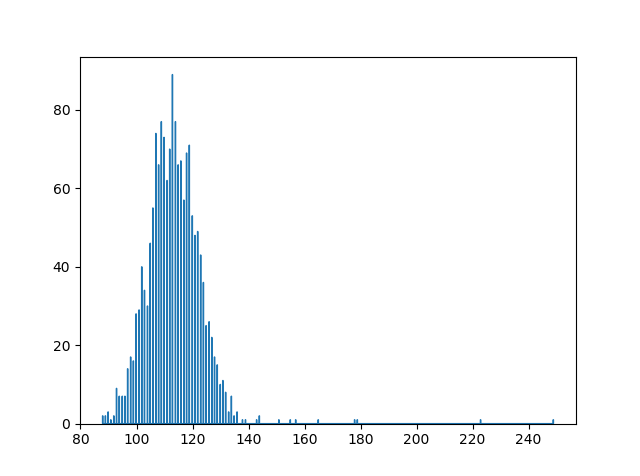

In [107]:
from IPython.display import Image
#Histogram of peak heights in filter cavity
Image(filename="phase8_threshold.png")

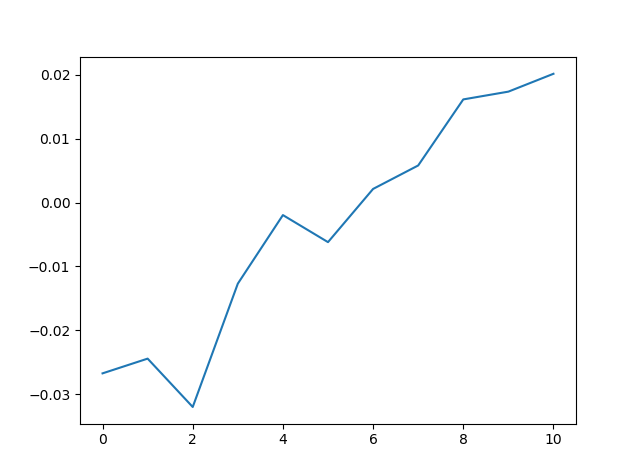

In [108]:
#The following few lines show what goes in the top of wignerCalculator.py to analyze the dataset

peak_width = 6

folder = "./data/Nov29/Nov_21_Data_Phase_6/Displacement_ND_7.7_both/"
filter_single_photon_level = 86
opo_single_photon_level = 86

photon_ranges = [150, 210] # 2peak min, 3 peak min
opo_photon_ranges = [180,240] #,310 for triple

Image(filename="Wigner_6_width.png")

The plot of the Wigner functions with increasing displacements are above. At 0 displacement, as expected the Wigner function is negative but increases to higher values at higher displacements. Although the general trend is correct, there are significant fluctuations in the calculated values. 